In [1]:
import os
import pathlib
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

%matplotlib inline

import settings
import utils

logger = utils.init_logger(f'final_mixed_plots', './outputs')

logger.info("Jupyter notebook start")

DATA_RESULTS = os.path.join(settings.DATA_PATH, "Results")

logger.info(f"Data results: {DATA_RESULTS}")

(root): Jupyter notebook start


(root): Data results: /Users/jmigual/Documents/Projects/CNNSurv/Data/Results


(matplotlib.backends): backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
from utils import all_results

# all_c_index(DATA_RESULTS + "/Model_scalar")
data_path = pathlib.Path(settings.DATA_PATH)
print(str(pathlib.Path(data_path / "Model_3").resolve()))

results = {
    'volume': {
        "mixed": all_results(DATA_RESULTS + "/Model_volume_LOOCV_3", "mixed"),  
        # "train": all_results(DATA_RESULTS + "/Model_volume_fix_2", "train"),
    },
    'scalar': {
        "mixed": all_results(DATA_RESULTS + "/Model_scalar_LOOCV_3", "mixed"),
        # "train": all_results(DATA_RESULTS + "/Model_scalar_fix_2", "train"),
    },
    'scalar_CV': {
        "mixed": all_results(DATA_RESULTS + "/Model_scalar_4CV_3", "mixed"),
        "train": all_results(DATA_RESULTS + "/Model_scalar_4CV_3", "train"),
        "test": all_results(DATA_RESULTS + "/Model_scalar_4CV_3", "test"),
    },
    # 'scalar_CV': {
    #     "mixed": all_results(str((data_path / "Model_3")), "mixed"),
    #     "train": all_results(str(data_path / "Model_3"), "train"),
    #     "test": all_results(str(data_path / "Model_3"), "test"),
    # },
    'volume_CV': {
        "mixed": all_results(DATA_RESULTS + "/Model_volume_4CV_3", "mixed"),
        "train": all_results(DATA_RESULTS + "/Model_volume_4CV_3", "train"),
        "test": all_results(DATA_RESULTS + "/Model_volume_4CV_3", "test"),
    },
    'shallow': {
        "mixed": all_results(DATA_RESULTS + "/Model_volume_4CV_3", "mixed"),
        "train": all_results(DATA_RESULTS + "/Model_volume_4CV_3", "train"),
        "test": all_results(DATA_RESULTS + "/Model_volume_4CV_3", "test"),
    },
    'residual': {
        "mixed": all_results(DATA_RESULTS + "/Model_residual", "mixed"),
        "train": all_results(DATA_RESULTS + "/Model_residual", "train"),
        "test": all_results(DATA_RESULTS + "/Model_residual", "test"),
    }
}

print("Done")

/Users/jmigual/Documents/Datasets/HNK/Model_3
(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_fix_3 mixed


(utils.results): Found 490


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_fix_3 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_fix_3 mixed


(utils.results): Found 490


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_fix_3 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_3 mixed


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_3 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_3 train


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_3 train



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_3 test


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_4CV_3 test



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 mixed


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 train


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 train



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 test


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 test



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 mixed


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 train


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 train



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 test


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_4CV_3 test



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_residual mixed


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_residual mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_residual train


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_residual train



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_residual test


(utils.results): Found 4


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_residual test



Done


scalar
Index(['id', 'right', 'total', 'censored', 'time', 'file', 'gather',
       'c-index'],
      dtype='object')
Count: 87042
Mean: 0.771082476029833
Median: 0.8619786707293848
Std: 0.24159774438931186
c-index cens 0.7713977160451276
c-index no cens 0.6169301085507523


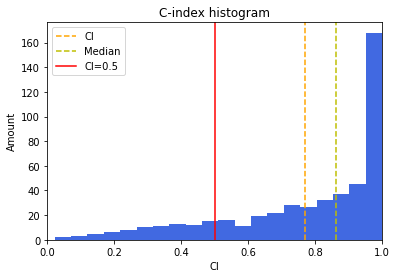

volume
Index(['id', 'right', 'total', 'censored', 'time', 'file', 'gather',
       'c-index'],
      dtype='object')
Count: 87042
Mean: 0.6265138353951369
Median: 0.6179775280898876
Std: 0.2108090013963158
c-index cens 0.62662852416075
c-index no cens 0.5704310290103473


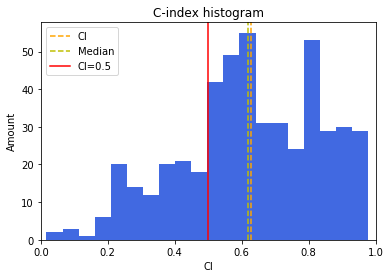

In [4]:
from matplotlib.lines import Line2D


def results_hits(cens_results: pd.DataFrame, uncens_results: pd.DataFrame, name):
    print(f"{name}")
    print(cens_results.columns)
    mean = cens_results['c-index'].mean()
    median = cens_results['c-index'].median()
    std = cens_results['c-index'].std()
    print(f"Count: {cens_results['total'].sum()}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Std: {std}")
    
    all_c_index = cens_results['right'].sum(axis=0)/cens_results['total'].sum(axis=0)
    
    print(f"c-index cens {all_c_index}")
    
    no_cens_c_index = uncens_results['right'].sum(axis=0)/uncens_results['total'].sum(axis=0)
    
    print(f"c-index no cens {no_cens_c_index}")
    
    n, bins, patches = plt.hist([
                                    cens_results['c-index'], 
                                    # uncens_results['c-index']
                                ],
                                bins=20,
                                label=['All', 'Non censored'],
                                color=[
                                    'royalblue', 
                                    # 'orange'
                                ])
    
    # max_val = max(map(lambda x: max(map(lambda y: y.get_height(), x)), patches))
    
    # n, bins, patches = plt.hist([cens_results['c-index']],
    #                             bins=20,
    #                             label=['All'],
    #                             color=['royalblue'],
    #                             range=(0, 1))
    # max_val = max(map(lambda x: x.get_height(), patches))
    
    plt.axvline(all_c_index, color='orange', linestyle='dashed')
    # plt.text(all_c_index, max_val*.8, 'CI all', rotation=90)
    # plt.text(all_c_index, 150, 'CI all', rotation=90)
    
    plt.axvline(.5, color='r')
    
    # plt.axvline(no_cens_c_index, color='black', linestyle='dashed')
    # plt.text(no_cens_c_index, max_val*.8, 'CI no censored', rotation=90)
    
    # plt.axvline(float(mean), color='g', linestyle='dashed')
    # plt.text(float(mean), max_val*.8, "mean", rotation=-90)

    plt.axvline(float(median), color='y', linestyle='dashed')
    # plt.text(float(median), max_val*.8, "median", rotation=-90)
    
    plt.xlim(0, 1)
    
    plt.xlabel("CI")
    plt.ylabel("Amount")
    
    ax = plt.gca()
    lines = [
        Line2D([0], [0], color='orange', linestyle='dashed'),
        # Line2D([0], [0], color='g', linestyle='dashed'),
        Line2D([0], [0], color='y', linestyle='dashed'),
        Line2D([0], [0], color='r'),
        # Line2D([0], [0], color='royalblue', lw=5),
        # Line2D([0], [0], color='orange', lw=5),
    ]
    ax.legend(lines, [
        "CI", 
        # "Mean", 
        "Median", 
        "CI=0.5", 
        # "All", 
        # "Uncensored"
    ])
    
    # plt.legend(loc='upper left')
    plt.title("C-index histogram")
    
    plt.savefig(f"outputs/c-index_{name}.png", dpi=300)
    plt.show()
    
    
results_hits(*(results['scalar']['mixed'][0]), "scalar")
results_hits(*(results['volume']['mixed'][0]), "volume")

# print("Scalar CV")
# results_hits(*(results['scalar_CV']['mixed'][0]), "scalar_mixed")
# results_hits(*(results['scalar_CV']['train'][0]), "scalar_train")
# results_hits(*(results['scalar_CV']['test'][0]), "scalar_test")
# 
# print("Volume CV")
# results_hits(*(results['volume_CV']['mixed'][0]), "volume_mixed")
# results_hits(*(results['volume_CV']['train'][0]), "volume_train")
# results_hits(*(results['volume_CV']['test'][0]), "volume_test")


In [5]:
def create_latex_table(all_dict):
    # print(r"\textbf{Fold} & \textbf{Train} & \textbf{Test} & \textbf{Mixed} & \textbf{Train} "
    #       r"& \textbf{Test} & \textbf{Mixed} \\")
    
    keys = list(all_dict.keys())
    
    res = ""
    for key in keys:
        res += r" & \textbf{" + f"{key.capitalize()}" + r"}"
    res = r"\textbf{Fold}" + res*2 + r" \\"
    print(res)
    
    length = len(all_dict['train'][0][0])
    for i in range(length):
        temp_total = f"{i}"
        temp_ci = ""
        for key in keys:
            sel_set, _ = all_dict[key][0]
            total = sel_set['total'].iloc[i]
            c_i = sel_set['right'].iloc[i]/total
            temp_total += f" & {total:,}"
            temp_ci += f" & {c_i:.3}"
        temp_ci += r" \\"
        print_str = temp_total + temp_ci
        print_str = print_str.replace(",", "[").replace(".", ",").replace("[", ".")
        print(print_str)
        
    res_total = r"\textbf{Total}"
    res_ci = ""
    for key in keys:
        sel_set, _ = all_dict[key][0]
        total = sel_set['total'].sum()
        c_i = sel_set['right'].sum()/total
        res_total += f" & {total:,}"
        res_ci += f" & {c_i:.3}"
    res_ci = res_ci + r" \\"
    print_str = res_total + res_ci
    print_str = print_str.replace(",", "[").replace(".", ",").replace("[", ".")
    print(res_total + res_ci)
    
    
print("Volume")
create_latex_table(results['volume_CV'])

print("Scalar")
create_latex_table(results['scalar_CV'])

print("Residual")
create_latex_table(results['residual'])
# create_latex_table(results['scalar'])
# create_latex_table(results['volume'])


Volume
\textbf{Fold} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} \\
0 & 16.359 & 46.804 & 5.330 & 0,627 & 0,634 & 0,639 \\
1 & 16.359 & 46.957 & 5.278 & 0,629 & 0,635 & 0,63 \\
2 & 16.348 & 47.577 & 5.084 & 0,636 & 0,627 & 0,661 \\
3 & 16.348 & 47.274 & 5.176 & 0,618 & 0,644 & 0,6 \\
\textbf{Total} & 65,414 & 188,612 & 20,868 & 0.627 & 0.635 & 0.632 \\
Scalar
\textbf{Fold} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} \\
0 & 16.359 & 46.804 & 5.330 & 0,728 & 0,915 & 0,543 \\
1 & 16.359 & 46.957 & 5.278 & 0,809 & 0,927 & 0,64 \\
2 & 16.348 & 47.577 & 5.084 & 0,751 & 0,91 & 0,675 \\
3 & 16.348 & 47.274 & 5.176 & 0,766 & 0,919 & 0,624 \\
\textbf{Total} & 65,414 & 188,612 & 20,868 & 0.764 & 0.918 & 0.62 \\
Residual
\textbf{Fold} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} & \textbf{Mixed} & \textbf{Train} & \textbf{Test} \\
0 & 222.048 & 330.072 & 37.016 & 0,562 & 0,565 & 0,5

Index(['id', 'right', 'total', 'censored', 'time', 'file', 'gather',
       'c-index'],
      dtype='object')


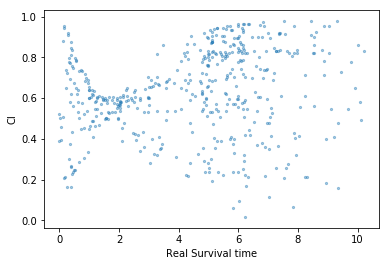

Index(['id', 'right', 'total', 'censored', 'time', 'file', 'gather',
       'c-index'],
      dtype='object')


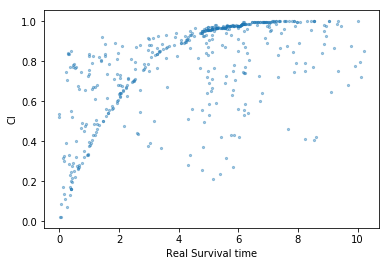

Index(['id', 'right', 'total', 'censored', 'time', 'file', 'gather',
       'c-index'],
      dtype='object')


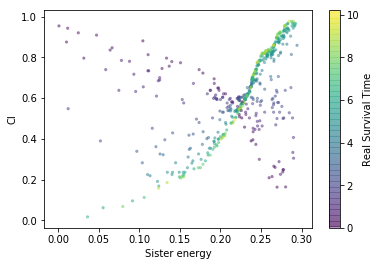

Index(['id', 'right', 'total', 'censored', 'time', 'file', 'gather',
       'c-index'],
      dtype='object')


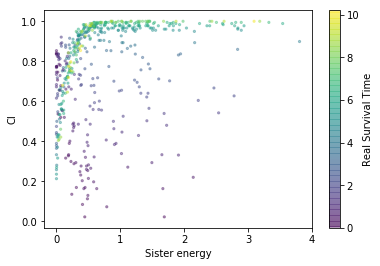

Index(['id', 'right', 'total', 'censored', 'time', 'file', 'gather',
       'c-index'],
      dtype='object')


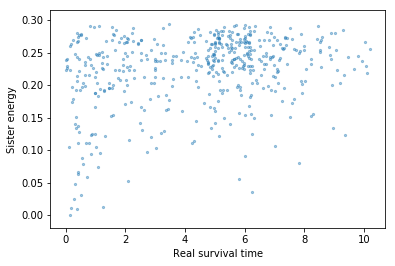

Index(['id', 'right', 'total', 'censored', 'time', 'file', 'gather',
       'c-index'],
      dtype='object')


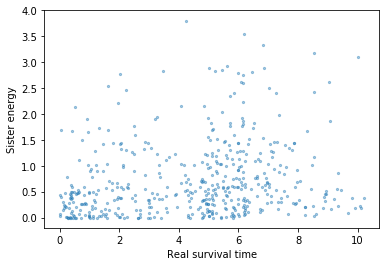

id                                                    FHBO100
right                                                       4
total                                                     177
censored                                                False
time                                                0.0246575
file        /Users/jmigual/Documents/Projects/CNNSurv/Data...
gather                                               0.442979
c-index                                             0.0225989
Name: 2, dtype: object
/Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_fix_3/fold_02/mixed_results.csv


In [13]:
def scatter_results(cens_results: pd.DataFrame, uncens_results: pd.DataFrame, name):
    print(cens_results.columns)
    plt.scatter(x=cens_results['time'], 
                y=cens_results['c-index'],
                # c=cens_results['time'],
                # cmap="viridis",
                label="Censored",
                s=5,
                alpha=.4)
    # plt.scatter(uncens_results['time'], 
    #             uncens_results['c-index'], label="Non censored", color="orange", s=5, alpha=.4)
    
    # less_pairs = cens_results.loc[cens_results['total'] < 100]
    # print(len(less_pairs))
    # plt.scatter(less_pairs['c-index'], less_pairs['total'], color='red', s=5)
    
    # plt.legend(loc='lower left')
    # cbar = plt.colorbar()
    # cbar.set_label("Real Survival Time")
    plt.xlabel("Real Survival time")
    plt.ylabel("CI")
    
    plt.savefig(f"outputs/scatter_time_ci_{name}.png", dpi=300)
    plt.show()
    
    
def scatter_gather_results(cens_results: pd.DataFrame, uncens_results: pd.DataFrame, name):
    print(cens_results.columns)
    plt.scatter(x=cens_results['gather'], 
                y=cens_results['c-index'], 
                c=cens_results['time'],
                cmap="viridis",
                label="Censored",
                s=5,
                alpha=.4)
    # plt.scatter(uncens_results['gather'], 
    #             uncens_results['c-index'], label="Non censored", color="orange", s=5, alpha=.4)
    
    # less_pairs = cens_results.loc[cens_results['total'] < 100]
    # print(len(less_pairs))
    # plt.scatter(less_pairs['c-index'], less_pairs['total'], color='red', s=5)
    
    # plt.legend(loc='lower left')
    cbar = plt.colorbar()
    cbar.set_label("Real Survival Time")
    plt.ylabel("CI")
    plt.xlabel("Sister energy")
    
    plt.savefig(f"outputs/scatter_gather_ci_{name}.png", dpi=300)
    plt.show()


def scatter_gather_time_results(cens_results: pd.DataFrame, uncens_results: pd.DataFrame, name):
    print(cens_results.columns)
    plt.scatter(x=cens_results['time'], 
                y=cens_results['gather'],
                # c=cens_results['time'],
                # cmap="viridis", 
                label="Censored", 
                s=5, 
                alpha=.4)
    # plt.scatter(uncens_results['time'], 
    #             uncens_results['gather'], label="Non censored", color="orange", s=5, alpha=.4)
    
    # less_pairs = cens_results.loc[cens_results['total'] < 100]
    # print(len(less_pairs))
    # plt.scatter(less_pairs['c-index'], less_pairs['total'], color='red', s=5)
    
    # plt.legend(loc='lower left')
    # cbar = plt.colorbar()
    # cbar.set_label("Real Survival Time")
    plt.ylabel("Sister energy")
    plt.xlabel("Real survival time")
    
    plt.savefig(f"outputs/scatter_time_gather_{name}.png", dpi=300)
    plt.show()


scatter_results(*(results['volume']['mixed'][0]), 'volume')
scatter_results(*(results['scalar']['mixed'][0]), 'scalar')
scatter_gather_results(*(results['volume']['mixed'][0]), 'volume')
scatter_gather_results(*(results['scalar']['mixed'][0]), 'scalar')
scatter_gather_time_results(*(results['volume']['mixed'][0]), 'volume')
scatter_gather_time_results(*(results['scalar']['mixed'][0]), 'scalar')

cens_scalar: pd.DataFrame = results['scalar']['mixed'][0][0]
cens_scalar = cens_scalar.sort_values('c-index', ascending=True)
# print(cens_scalar)

print(cens_scalar.iloc[0])
print(cens_scalar.iloc[0]['file'])

idx = cens_scalar.iloc[0]['id']
# print(results['scalar']['mixed'][1])


In [39]:

def roc_plot(models: List[Tuple[str, pd.DataFrame]]):
    plt.plot([0, 1], [0, 1], color='navy', linestyle='dashed')
    for name, predictions in models:
        fpr, tpr, _ = roc_curve(predictions['labels'], predictions['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"ROC {name} (area = {roc_auc:.2})")
        
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    plt.show()


roc_plot([('Features', results['scalar'][1]), ('Volume', results['volume'][1])])

KeyError: 1

In [40]:

features = pd.read_csv(settings.DATA_PATH_RADIOMIC_PROCESSED, index_col=0)
volumes = features.values[settings.VOLUME_FEATURE_INDEX]
volumes

array([ 43733.55202 ,  22302.60473 ,  26906.93961 , 156163.4043  ,
        16942.96056 ,  10349.26308 ,  29382.6756  ,  16585.38393 ,
         1577.375704,  28644.53244 ,  60180.60244 ,  34103.35863 ,
        18855.28934 ,  42915.30029 ,  57630.47993 ,  11665.33229 ,
        17843.65363 ,  77224.65237 ,  27931.18478 ,  30093.25997 ,
         7171.623516,  18438.32035 ,  23143.50321 ,  30920.61696 ,
         5411.14253 ,  35197.6832  ,  23353.55275 ,   8943.548581,
        45474.95954 ,  26740.71347 ,  54027.50205 ,  13200.79821 ,
        42497.59137 ,  36164.32888 ,  52083.91578 ,  75731.19992 ,
        20746.20984 ,  19061.04576 ,  11726.21056 ,  48432.77414 ,
        63852.2448  ,   2377.076544,  40332.75289 ,  13637.52876 ,
        21524.40728 ,  10103.21536 ,  27676.76107 ,  23296.33235 ,
        20282.24819 ,  21516.77789 ,  10993.94626 ,  25439.72069 ,
         9889.592534,  15386.67179 ,   1188.276981,  70726.3326  ,
         6709.945344,   9893.454336,  45862.7241  ,  48822.352